In [ ]:
# Mount Google Drive on Google Colab
from google.colab import drive
drive.mount('/content/drive')
corpus = '/content/drive/My Drive/hi_hdtb-ud-train.txt'
import collections
import math
import numpy as np
import os
import random
import tensorflow.compat.v1 as tf
import zipfile
import string
import re
import pickle

from __future__ import print_function
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

%matplotlib inline
hindi_font = FontProperties(fname=os.path.join(corpus, 'Nirmala.ttf'))
def clean_text(sentence, language):
    """
        Input: String, String
        Output: String
        Takes in text as string. Returns text cleaned for NMT purposes.
    """
    if language == None:
        print("Please enter which language.")
        return None
        
    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)
        
    if language == 'en':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'hi':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)

        sent_temp = ''
        for c in sentence:
            if c == ' ':
                sent_temp += c
            elif ord(u'\u0900') <= ord(c) <= ord(u'\u097F'):
                sent_temp += c
        sentence = sent_temp
      
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    elif language == 'ma':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence
    
    else:
        print("Language not found")
        return None
def read_data(filename, number_of_lines):
    data = list()
    
    with open(corpus) as f:
        for i in  range(number_of_lines):
            data.extend(clean_text(tf.compat.as_str(f.readline()).strip(), 'hi').split(' '))
    return data

words = read_data('monolingual.hi', 5000000)
print("Data size %d" % len(words))
vocabulary_size = int(len(set(words)) // 1.2)

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Vocabulary size", vocabulary_size)
print("Most common words (+UNK)", count[:5])
print("Sample data", data[:10])
del words
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print("Data:", [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print("\nwith num_skips = %d and skip_window = %d:" % (num_skips, skip_window))
    print("    batch:", [reverse_dictionary[bi] for bi in batch])
    print("    labels:", [reverse_dictionary[di] for di in labels.reshape(8)])
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                    labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            print("Average loss at step %d: %f" % (step, average_loss))
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
final_data = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}
with open('embeddings.pickle', 'wb') as f:
    pickle.dump(file=f, obj=final_data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data size 5242445
Vocabulary size 13284
Most common words (+UNK) [['UNK', 2658], ('', 4982787), ('के', 12883), ('में', 8421), ('की', 7475)]
Sample data [23, 1297, 4, 183, 438, 9296, 3, 8, 20, 5]
Data: ['यह', 'एशिया', 'की', 'सबसे', 'बड़ी', 'मस्जिदों', 'में', 'से']

with num_skips = 2 and skip_window = 1:
    batch: ['एशिया', 'एशिया', 'की', 'की', 'सबसे', 'सबसे', 'बड़ी', 'बड़ी']
    labels: ['की', 'यह', 'सबसे', 'एशिया', 'बड़ी', 'की', 'मस्जिदों', 'सबसे']

with num_skips = 4 and skip_window = 2:
    batch: ['की', 'की', 'की', 'की', 'सबसे', 'सबसे', 'सबसे', 'सबसे']
    labels: ['सबसे', 'यह', 'बड़ी', 'एशिया', 'मस्जिदों', 'बड़ी', 'की', 'एशिया']
Initialized
Average loss at step 0: 6.593600
Nearest to से: अहाते, सिल्वियो, शेखावत, वाला, फेंका, शिविरों, शान, लालटेन,
Nearest to भी: ओवरहॉल, दिशा, जलबेड़ा, अवकाश, कोलंबिया, सीट, बल, रिसाव,
Nearest to कुछ: पात्र, हस्ताक्षर, हर्

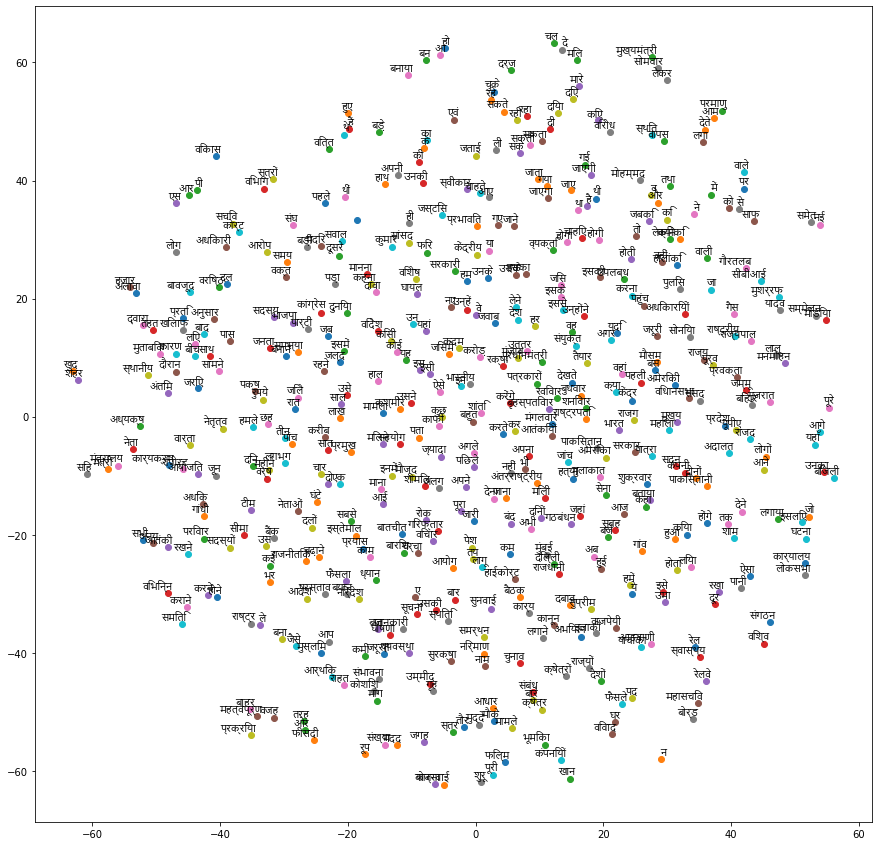

In [ ]:
import pickle
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from sklearn.manifold import TSNE

%matplotlib inline
hindi_font = FontProperties(fname='./Nirmala.ttf')

with open ("./embeddings.pickle", "rb") as f:
  e = pickle.load(f)
  num_points = 500

final_embeddings = e['embeddings']
reverse_dictionary = e['reverse_dictionary']

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=hindi_font)
    pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)